In [1]:
import math
import pandas as pd

from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [ ]:
def map_labels(x):
    # print(x)
    if type(x) is str:
        x = x.replace('\u200c', '').replace('.', '')
    if x == 'important' or x == '\'important\'' or x == '1' or x == '\'1\'' or x == '58' or x == 58 or x == '\'58\'' or x == '(1)' or x == '۱':
        return 1
    elif x == 'not important' or x == '\'not important\'' or x == '0' or x == '\'0\'' or x == '47' or x == 47 or x == '\'47\'' or x == '۰':
        return 0
    # print(x)
    if math.isnan(x):
        return x
    return int(x)

In [3]:
aya_df = pd.read_csv('../Datasets/System_Prompt24_Results.csv')
# columns_to_evaluate = ['predicted_k_0', 'predicted_k_1', 'predicted_k_5', 'predicted_k_20', 'predicted_k_50']
columns_to_evaluate = ['predicted_k_20']

In [4]:
aya_df.head(5)

,text,text_type,real_tag,category,predicted_k_0,predicted_k_1,predicted_k_2,predicted_k_3,predicted_k_4,predicted_k_5,predicted_k_10,predicted_k_20,predicted_k_50
0,واکنش کنسولگری ایران در استانبول به ریجکت شدن ...,only_title,0,اجتماعی,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN
1,برگزاری دادگاه پرونده کثیرالشاکی شرکت کاغذی «آ...,only_title,0,اجتماعی,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN
2,خبر جدید وزیر بهداشت درباره بازگشایی مدارس در ...,only_title,1,اجتماعی,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN
3,شکایت باشگاه استقلال از عیسی آل کثیر,only_title,1,ورزشی,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN
4,دولت فرانسه مسئول عواقب اهانت بی‌شرمانه علیه م...,only_title,0,سیاسی,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN


In [5]:
aya_df['real_tag'] = aya_df['real_tag'].apply(map_labels)
for column in columns_to_evaluate:
    aya_df[column] = aya_df[column].apply(map_labels)

0
0
1
1
0
0
0
0
0
0
1
0
0
0
0
0
0
0
1
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
1
0
0
0
1
0
1
1
0
0
0
0
0
0
0
1
1
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
1
0
1
0
0
1
0
0
1
0
0
0
0
0
0
0
1
1
1
0
0
0
0
1
0
0
0
1
0
0
1
0
0
0
0
1
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
1
0
0
1
0
0
1
0
0
0
0
1
1
0
1
0
0
0
0
1
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
1
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
1
1
1
0
0
0
0
0
0
0
0
0
1
1
0
0
1
0
1
0
0
0
0
0
1
0
1
0
0
0
0
0
1
0
0
0
1
1
0
0
1
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
1
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
1
0
1
0
0
1
0
0
1
0
0
0
1
0
0
0
0
0
1
0
1
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
1
1
0
0
1
0
0
1
0
0
1
0
1
0
0
0
0
0
0
0
0
1
0
1
1
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
1
0
0
0
1
0
0
0
1
0
1
1
0
0
1
0
0
1
0
0
0
0
1
0
0
0
0
0
1
0
0
0
0
1
0
0
0
0
0
1
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
1
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0


In [6]:
aya_df.tail(5)

,text,text_type,real_tag,category,predicted_k_0,predicted_k_1,predicted_k_2,predicted_k_3,predicted_k_4,predicted_k_5,predicted_k_10,predicted_k_20,predicted_k_50
1174,بازار متشکل ارزی در روز 15 خرداد فعال خواهد بود,only_title,0,اقتصادی,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN
1175,قیمت سکه پارسیان امروز یکشنبه هشتم اسفند ماه ۱۴۰۰,only_title,0,اقتصادی,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN
1176,انتقال ۱۰۰ میلیون یورویی بعدی کدام بازیکن است ...,only_title,0,ورزشی,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN
1177,مبارزه علیه آپارتاید اسرائیل بخشی از جریان مقا...,only_title,0,سیاسی,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN
1178,آیا قیمت گوشت قرمز در تابستان افسار پاره می‌کند؟,only_title,1,اقتصادی,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN


In [7]:
true_labels = aya_df['real_tag'].dropna()
true_labels_first_400 = aya_df['real_tag'].dropna().iloc[:401]

# num_true1 = (true_labels_first_400 == 1).sum()
# num_true0 = (true_labels_first_400 == 0).sum()

num_true1 = (true_labels == 1).sum()
num_true0 = (true_labels == 0).sum()

print(f"  Number of true '1' labels: {num_true1}")
print(f"  Number of true '0' labels: {num_true0}")

  Number of true '1' labels: 196
  Number of true '0' labels: 983


In [8]:
for column in columns_to_evaluate:

    pred_labels = aya_df[column].dropna()

    common_indices = true_labels.index.intersection(pred_labels.index)

    true_labels = true_labels.loc[common_indices]
    pred_labels = pred_labels.loc[common_indices]

    for index, pred_label in enumerate(pred_labels):
        if pred_label != 0 and pred_label != 1:
            print(index)
            print(pred_label)
            pred_labels[index] = 1

    for index, true_label in enumerate(true_labels):
        if true_label != 0 and true_label != 1:
            print(index)
            print(true_label)

    accuracy = accuracy_score(true_labels, pred_labels)
    precision = precision_score(true_labels, pred_labels)
    recall = recall_score(true_labels, pred_labels)
    f1 = f1_score(true_labels, pred_labels)

    num_58 = (aya_df[column] == 1).sum()
    num_47 = (aya_df[column] == 0).sum()

    print(f"Metrics for column {column}:")
    print(f"  Accuracy: {accuracy:.2f}")
    print(f"  Precision: {precision:.2f}")
    print(f"  Recall: {recall:.2f}")
    print(f"  F1 Score: {f1:.2f}")
    print(f"  Number of '58' labels: {num_58}")
    print(f"  Number of '47' labels: {num_47}")
    print("\n")


Metrics for column predicted_k_20:
  Accuracy: 0.82
  Precision: 0.45
  Recall: 0.54
  F1 Score: 0.49
  Number of '58' labels: 231
  Number of '47' labels: 948




In [9]:
for column in columns_to_evaluate:

    pred_labels = aya_df[column].dropna()
    aya_df[column] = aya_df[column].apply(map_labels)

    common_indices = true_labels.index.intersection(pred_labels.index)
    true_labels_common = true_labels.loc[common_indices]
    pred_labels_common = pred_labels.loc[common_indices]

    print(f"Metrics for column {column}:")

    report = classification_report(true_labels_common, pred_labels_common, target_names=['0', '1'])
    print(report)

    num_1 = (aya_df[column] == 1).sum()
    num_0 = (aya_df[column] == 0).sum()

    print(f"  Number of '1' labels: {num_58}")
    print(f"  Number of '0' labels: {num_47}")
    print("\n")

0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
1
0
1
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
1
1
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
1
0
0
0
1
1
0
0
0
0
0
0
1
1
0
0
0
0
0
1
0
1
0
1
0
0
0
0
0
1
0
0
1
0
0
0
0
0
0
0
1
0
1
1
0
1
0
0
0
1
1
1
0
0
1
0
0
0
0
0
0
0
1
0
0
0
0
1
0
0
0
1
0
1
0
0
1
0
0
0
0
1
1
1
0
0
0
1
0
0
1
1
0
0
0
0
1
0
0
0
0
0
0
0
0
1
1
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
1
0
0
0
0
1
1
1
0
0
0
0
0
0
1
0
0
0
0
0
0
0
1
0
1
0
0
0
0
0
0
0
1
0
0
0
1
0
1
0
0
0
1
0
0
0
0
1
0
0
0
0
0
0
0
0
0
1
1
0
0
0
0
0
1
1
0
0
0
0
0
0
0
0
0
0
0
1
0
1
0
0
0
0
0
0
0
0
1
0
1
0
0
1
0
0
0
0
1
0
0
1
1
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
1
0
0
0
1
1
0
0
0
0
0
0
0
0
0
0
1
0
1
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
1
1
1
0
0
0
1
0
0
0
1
0
1
0
0
0
1
0
0
0
1
0
0
0
0
0
0
1
0
0
0
1
0
1
1
0
0
1
1
0
0
0
0
1
0
0
0
0
0
0
1
0
0
0
0
1
0
1
0
1
0
0
0
0
0
0
0
0
0
0
0
0
1
1
0
1
0
1
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


### *kfold Measurment*

In [10]:
from sklearn.model_selection import KFold
import numpy as np

In [11]:
n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

In [12]:
macro_avg_precision_scores = []
macro_avg_recall_scores = []
macro_avg_f1_scores = []
macro_avg_accuracy_scores = [] 

In [13]:
for fold, (train_index, test_index) in enumerate(kf.split(aya_df)):
    print(f"\nFold {fold + 1}/{n_splits}")

    train_df = aya_df.iloc[train_index]
    test_df = aya_df.iloc[test_index]

    train_df['real_tag'] = train_df['real_tag'].apply(map_labels)
    test_df['real_tag'] = test_df['real_tag'].apply(map_labels)

    for column in columns_to_evaluate:
        train_df[column] = train_df[column].apply(map_labels)
        test_df[column] = test_df[column].apply(map_labels)

        true_labels_test = test_df['real_tag'].dropna()
        pred_labels_test = test_df[column].dropna()

        common_indices_test = true_labels_test.index.intersection(pred_labels_test.index)
        
        true_labels_test = true_labels_test.loc[common_indices_test]
        pred_labels_test = pred_labels_test.loc[common_indices_test]

        accuracy = accuracy_score(true_labels_test, pred_labels_test)
        report_dict = classification_report(true_labels_test, pred_labels_test, target_names=['0', '1'], output_dict=True)

        macro_avg_precision = report_dict['macro avg']['precision']
        macro_avg_recall = report_dict['macro avg']['recall']
        macro_avg_f1 = report_dict['macro avg']['f1-score']

        macro_avg_accuracy_scores.append(accuracy)
        macro_avg_precision_scores.append(macro_avg_precision)
        macro_avg_recall_scores.append(macro_avg_recall)
        macro_avg_f1_scores.append(macro_avg_f1)

        print(f"\nMetrics for column {column} in fold {fold + 1}:")
        report = classification_report(true_labels_test, pred_labels_test, target_names=['0', '1'])
        print(report)


Fold 1/5
0
0
1
1
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
1
0
1
0
1
0
0
0
0
0
0
1
1
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
1
0
0
0
0
1
0
1
0
0
1
0
0
1
0
0
0
0
0
1
1
1
0
0
0
0
1
0
0
1
0
0
0
0
1
0
0
1
0
0
0
0
0
0
0
0
0
1
0
1
0
1
0
1
0
0
0
0
1
1
0
1
0
0
0
0
1
0
0
0
0
0
1
0
0
0
0
0
0
1
0
1
0
0
0
0
0
0
0
0
0
1
1
0
0
0
0
0
0
0
1
0
0
1
0
1
0
0
0
0
1
0
0
0
0
0
1
0
0
0
1
1
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
1
0
0
0
0
0
0
0
1
0
0
0
0
0
0
1
0
0
0
1
0
0
1
0
0
1
0
0
0
0
0
0
0
1
0
1
0
0
0
0
0
0
0
1
0
0
0
0
0
0
1
1
0
0
1
0
0
0
1
0
1
0
0
0
0
0
1
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
1
0
0
0
1
0
1
1
0
0
0
0
1
0
0
0
0
0
0
1
0
0
1
0
0
0
0
1
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
1
0
0
0
0


C:\Users\ROG\AppData\Local\Temp\ipykernel_6692\944186713.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['real_tag'] = train_df['real_tag'].apply(map_labels)
C:\Users\ROG\AppData\Local\Temp\ipykernel_6692\944186713.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['real_tag'] = test_df['real_tag'].apply(map_labels)
C:\Users\ROG\AppData\Local\Temp\ipykernel_6692\944186713.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

In [14]:
print("\n=== K-Fold Cross Validation Results (Macro Avg) ===")
print(f"Accuracy: Mean={np.mean(macro_avg_accuracy_scores):.4f}, Variance={np.var(macro_avg_accuracy_scores):.4f}")
print(f"Precision (Macro Avg): Mean={np.mean(macro_avg_precision_scores):.4f}, Variance={np.var(macro_avg_precision_scores):.4f}")
print(f"Recall (Macro Avg): Mean={np.mean(macro_avg_recall_scores):.4f}, Variance={np.var(macro_avg_recall_scores):.4f}")
print(f"F1 Score (Macro Avg): Mean={np.mean(macro_avg_f1_scores):.4f}, Variance={np.var(macro_avg_f1_scores):.4f}")


print(f"\nAccuracy: Range={np.max(macro_avg_accuracy_scores) - np.min(macro_avg_accuracy_scores):.4f}")
print(f"Precision (Macro Avg): Range={np.max(macro_avg_precision_scores) - np.min(macro_avg_precision_scores):.4f}")
print(f"Recall (Macro Avg): Range={np.max(macro_avg_recall_scores) - np.min(macro_avg_recall_scores):.4f}")
print(f"F1 Score (Macro Avg): Range={np.max(macro_avg_f1_scores) - np.min(macro_avg_f1_scores):.4f}")


=== K-Fold Cross Validation Results (Macro Avg) ===
Accuracy: Mean=0.8159, Variance=0.0002
Precision (Macro Avg): Mean=0.6789, Variance=0.0003
Recall (Macro Avg): Mean=0.7037, Variance=0.0006
F1 Score (Macro Avg): Mean=0.6885, Variance=0.0004

Accuracy: Range=0.0381
Precision (Macro Avg): Range=0.0487
Recall (Macro Avg): Range=0.0760
F1 Score (Macro Avg): Range=0.0517


### *F1 Calculation*

In [15]:
import pandas as pd
import numpy as np
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import arabic_reshaper
from bidi.algorithm import get_display

In [16]:
def normalize_numbers(column):
    persian_to_english = {
        '۰': '0', '۱': '1', '۲': '2', '۳': '3', '۴': '4', 
        '۵': '5', '۶': '6', '۷': '7', '۸': '8', '۹': '9'
    }
    column = column.astype(str)
    for persian_num, eng_num in persian_to_english.items():
        column = column.str.replace(persian_num, eng_num)
    return pd.to_numeric(column, errors='coerce').fillna(0).astype(int)

In [17]:
def reshape_persian_text(text):
    reshaped_text = arabic_reshaper.reshape(text)
    return get_display(reshaped_text)

In [18]:
def calculate_f1_scores(df, col_true, col_pred=None, category_col='category'): 
    if col_pred is None:
        col_pred = 'tag'
    
    y_true = normalize_numbers(df[col_true])
    y_pred = normalize_numbers(df[col_pred])
    
    f1_macro = f1_score(y_true, y_pred, average='macro')
    f1_micro = f1_score(y_true, y_pred, average='micro')
    precision = precision_score(y_true, y_pred, average='macro')
    recall = recall_score(y_true, y_pred, average='macro')
    
    conf_matrix = confusion_matrix(y_true, y_pred)
    conf_matrix_normalized = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix_normalized, annot=True, fmt='.2%', cmap='Blues')
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()
    
    unique_categories = df[category_col].unique()
    category_f1_scores = {}
    
    for category in unique_categories:
        category_mask = (df[category_col] == category)
        y_true_cat = y_true[category_mask]
        y_pred_cat = y_pred[category_mask]
        
        f1_macro_cat = f1_score(y_true_cat, y_pred_cat, average='macro')
        f1_micro_cat = f1_score(y_true_cat, y_pred_cat, average='micro')
        precision_cat = precision_score(y_true_cat, y_pred_cat, average='macro')
        recall_cat = recall_score(y_true_cat, y_pred_cat, average='macro')
        
        category_f1_scores[category] = {
            'F1 Macro': round(f1_macro_cat, 4),
            'F1 Micro': round(f1_micro_cat, 4),
            'Precision': round(precision_cat, 4),
            'Recall': round(recall_cat, 4)
        }
    
    category_f1_scores['Overall'] = {
        'F1 Macro': round(f1_macro, 4),
        'F1 Micro': round(f1_micro, 4),
        'Precision': round(precision, 4),
        'Recall': round(recall, 4),
    }
    
    category_f1_scores = {reshape_persian_text(cat): metrics for cat, metrics in category_f1_scores.items()}
    
    print("\nCategory-wise F1 Scores:")
    for category, metrics in category_f1_scores.items():
        print(f"\nCategory: {category}")
        for metric, value in metrics.items():
            print(f"{metric}: {value}")
    
    metrics_df = pd.DataFrame.from_dict(category_f1_scores, orient='index')
    
    metrics_df.plot(kind='bar', figsize=(10, 6))
    plt.title(reshape_persian_text("Category-wise and Overall F1, Precision, and Recall"))
    plt.ylabel("Score")
    plt.xlabel(reshape_persian_text("Category"))
    plt.legend(loc="upper right")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(12, 6))
    plt.axis('off')
    table = plt.table(cellText=metrics_df.values,
                      colLabels=metrics_df.columns,
                      rowLabels=metrics_df.index,
                      loc='center',
                      cellLoc='center',
                      colWidths=[0.2] * len(metrics_df.columns))
    
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1.2, 1.2) 
    plt.title(reshape_persian_text("F1, Precision, and Recall Summary Table"), pad=20)
    plt.show()

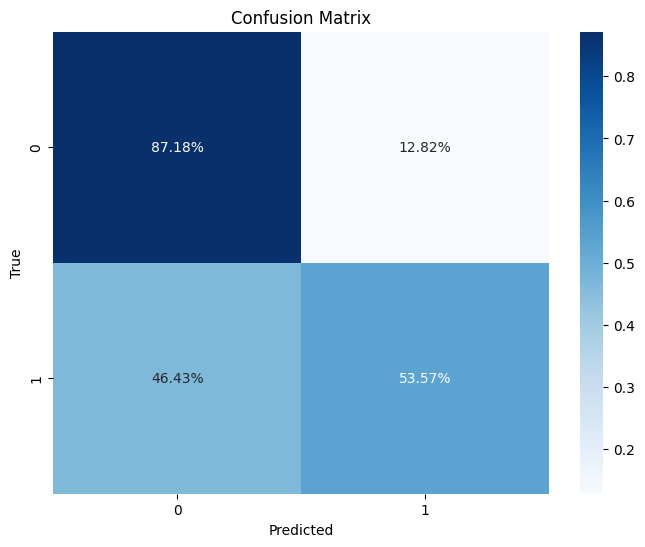

c:\Program Files\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Category-wise F1 Scores:

Category: ﯽﻋﺎﻤﺘﺟﺍ
F1 Macro: 0.6616
F1 Micro: 0.8327
Precision: 0.6737
Recall: 0.6523

Category: ﯽﺷﺯﺭﻭ
F1 Macro: 0.6886
F1 Micro: 0.7852
Precision: 0.6762
Recall: 0.7098

Category: ﯽﺳﺎﯿﺳ
F1 Macro: 0.6608
F1 Micro: 0.8159
Precision: 0.6418
Recall: 0.7023

Category: ﯼﺮﻨﻫ ﻭ ﯽﮕﻨﻫﺮﻓ
F1 Macro: 0.6866
F1 Micro: 0.9487
Precision: 0.6383
Recall: 0.8114

Category: ﻥﺎﻬﺟ ﺭﺎﺒﺧﺍ
F1 Macro: 0.682
F1 Micro: 0.8841
Precision: 0.6415
Recall: 0.8212

Category: ﯼﺩﺎﺼﺘﻗﺍ
F1 Macro: 0.7057
F1 Micro: 0.7268
Precision: 0.702
Recall: 0.7125

Category: ﯼﮊﻮﻟﻮﻨﮑﺗ ﻭ ﻢﻠﻋ
F1 Macro: 0.5708
F1 Micro: 0.7778
Precision: 0.5873
Recall: 0.5645

Category: ﯽﮑﺷﺰﭘ ﻭ ﺖﻣﻼﺳ
F1 Macro: 0.4211
F1 Micro: 0.7273
Precision: 0.3636
Recall: 0.5

Category: Overall
F1 Macro: 0.6897
F1 Micro: 0.8159
Precision: 0.6793
Recall: 0.7038


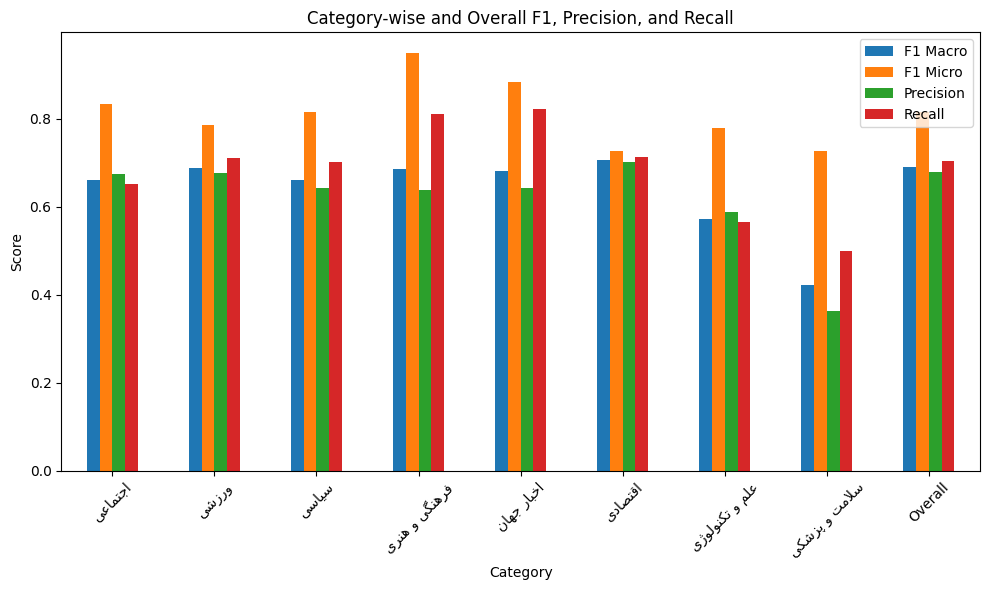

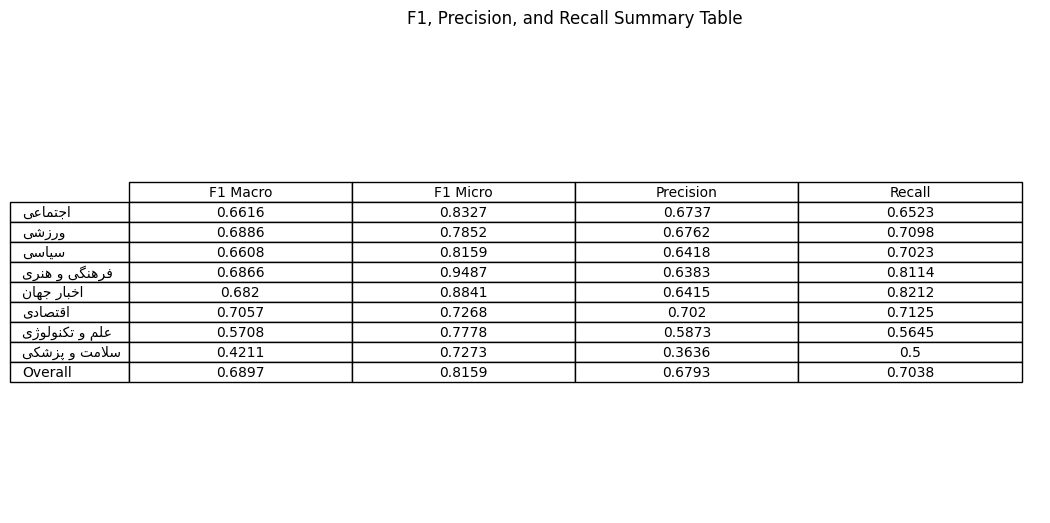

In [19]:
calculate_f1_scores(
    df=aya_df,
    col_true='real_tag',
    col_pred='predicted_k_20',
    category_col='category'
)